In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
import pertpy
import yaml

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from DE_analysis_utils import *


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/ipykernel/kernelapp.py", lin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/ipykernel/kernelapp.py", lin

AttributeError: _ARRAY_API not found

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

In [135]:
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [4]:
OAKPATH  = '/mnt/oak/'

## Load gene lists

In [65]:
import json
import re

def extract_genes_from_kegg_json(json_file_path):
    """
    Extract all gene names from KEGG cytokine receptor JSON file.
    
    Args:
        json_file_path (str): Path to the JSON file
    
    Returns:
        list: List of gene names (e.g., ['IL2RA', 'IL2RB', ...])
    """
    
    def extract_genes_recursive(node):
        """Recursively extract genes from nested structure"""
        genes = []
        
        if isinstance(node, dict):
            # Check if this node has a 'name' field with gene info
            if 'name' in node:
                name = node['name']
                # Look for pattern: "number GENE_NAME; description"
                match = re.match(r'^\d+\s+(\w+);', name)
                if match:
                    gene_name = match.group(1)
                    genes.append(gene_name)
            
            # Recursively process children
            if 'children' in node:
                for child in node['children']:
                    genes.extend(extract_genes_recursive(child))
        
        elif isinstance(node, list):
            # If it's a list, process each item
            for item in node:
                genes.extend(extract_genes_recursive(item))
                
        return genes
    
    # Load JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Extract genes
    genes = extract_genes_recursive(data)
    
    # Remove duplicates and sort
    unique_genes = sorted(list(set(genes)))
    
    return unique_genes

# KEGG cytokines and receptors
gene_list = extract_genes_from_kegg_json('../../metadata/hsa04050.json')
# Optional: Save to file
with open('../../metadata/cytokine_receptors.tsv', 'w') as f:
    for gene in gene_list:
        f.write(gene + '\n')


gene_list = extract_genes_from_kegg_json('../../metadata/hsa04052.json')
# Optional: Save to file
with open('../../metadata/gene_lists/cytokines.tsv', 'w') as f:
    for gene in gene_list:
        f.write(gene + '\n')


In [97]:
gene_list_labels = {
    'kinases': 'Protein Kinases',
    # 'core_essentials_hart': 'Core Essential Genes (Hart et al.)',
    'clinvar_path_likelypath': 'ClinVar disease genes',
    'gpi_anchored': 'GPI-Anchored Proteins',
    'transporters': 'Membrane Transporters',
    'gwascatalog': 'Genes near GWAS peaks',
    'rhodop_gpcr': 'Rhodopsin GPCRs',
    'enzymes': 'Enzymes',
    'catalytic_receptors': 'Catalytic Receptors',
    'gpcr_union': 'GPCRs',
    'nuclear_receptors': 'Nuclear Receptors',
    'ion_channels': 'Ion Channels',
    'olfactory_receptors': 'Olfactory Receptors',
    'IEI genes': 'Inborn Errors of Immunity Genes',
    'cytokines': 'Cytokines (KEGG)',
    'cytokine_receptors': 'Cytokine receptors (KEGG)',
    'Schmidt2022 IL2 CRISPRi pos': 'IL2 Positive Regulators (Schmidt 2022)',
    'Schmidt2022 IL2 CRISPRi neg': 'IL2 Negative Regulators (Schmidt 2022)'
}

lists_dict = {}

for f in os.listdir(f"../../metadata/gene_lists/"):
    key = f.split('.')[0]
    if key in gene_list_labels.keys():
        lists_dict[gene_list_labels[key]] = [g.strip() for g in open(f"../../metadata/gene_lists/{f}")]

# Inborn errors of immunity
IEI_genes = pd.read_csv('../../metadata/IUIS-IEI-list-July-2024V2.csv')
lists_dict['Inborn Errors of Immunity Genes'] = IEI_genes['Genetic defect'].unique()

# Activation screens
schmidt_df = pd.read_csv('../../metadata/SchmidtSteinhart2022_CRISPRi_screen_gene_phenotypes.csv')
lists_dict['IL2 Positive Regulators (Schmidt 2022)'] = schmidt_df[(schmidt_df['phenotype'] == 'Prim.CRi.CD4.IL2') & (schmidt_df['pvalue'] < 0.01) & (schmidt_df.effect_size < 0)]['target'].tolist()
lists_dict['IL2 Negative Regulators (Schmidt 2022)'] = schmidt_df[(schmidt_df['phenotype'] == 'Prim.CRi.CD4.IL2') & (schmidt_df['pvalue'] < 0.01) & (schmidt_df.effect_size > 0)]['target'].tolist()


## Read DE analysis results

In [6]:
# Import utility functions from DE_analysis_utils.py
import sys
sys.path.append(os.path.abspath('../3_DE_analysis'))
from DE_analysis_utils import get_DE_results_long


In [7]:
datadir = f'{OAKPATH}/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    
adata_de.var_names = adata_de.var['gene_name'].values
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ARHGAP11B', 'LINC02929', 'CDR1', 'PRRC2B', 'F8A1', 'HOMEZ', 'C2orf83',
       'ENSG00000290797', 'ENSG00000291096', 'SOD2'],
      dtype='object', length=13959)

In [8]:
# Load summary stats
DE_stats_targets = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
ontarget_df = pd.read_csv(f'{datadir}/DE_results_all_confounders/on_target_effects.csv')
DE_stats_targets['n_regulators'] = np.where(DE_stats_targets['ontarget_significant'], DE_stats_targets['n_total_de_genes'] - 1, DE_stats_targets['n_total_de_genes'])
DE_stats_targets.head()

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,n_regulators
0,ENSG00000012963,UBR7,Stim8hr,491.0,0,2,2,-12.952742,True,43.169196,True,2-10 DE genes,on-target KD,1
1,ENSG00000017260,ATP2C1,Stim8hr,469.0,0,1,1,-16.307246,True,102.399025,False,1 DE gene,on-target KD,0
2,ENSG00000067606,PRKCZ,Stim8hr,427.0,1,1,2,-1.658755,False,0.965897,False,2-10 DE genes,no on-target KD,2
3,ENSG00000092929,UNC13D,Stim8hr,830.0,0,2,2,-19.259466,True,60.904483,False,2-10 DE genes,on-target KD,1
4,ENSG00000100504,PYGL,Stim8hr,414.0,1,0,1,NaN,False,NaN,False,1 DE gene,no on-target KD,1


In [9]:
DE_stats_genes = pd.concat([
    get_de_stats(adata_de[adata_de.obs['culture_condition'] == c], alpha=0.1, signif_col='adj_p_value', effect_col='zscore', axis='genes').assign(culture_condition=c)
    for c in adata_de.obs['culture_condition'].unique()
])
DE_stats_genes = pd.merge(DE_stats_genes, ontarget_df[['gene_name', 'culture_condition', 'significant', 'baseMean']], how='left')
DE_stats_genes['significant'] = DE_stats_genes['significant'].fillna(False)
DE_stats_genes['baseMean'] = DE_stats_genes['baseMean'].fillna(0)
DE_stats_genes['n_regulators'] = np.where(DE_stats_genes['significant'], DE_stats_genes['n_total_de_targets'] - 1, DE_stats_genes['n_total_de_targets'])
DE_stats_genes.head()

/tmp/ipykernel_1268825/459124982.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DE_stats_genes['significant'] = DE_stats_genes['significant'].fillna(False)


,gene_id,gene_name,n_up_targets,n_down_targets,n_total_de_targets,culture_condition,significant,baseMean,n_regulators
0,ENSG00000000003,TSPAN6,0,0,0,Stim8hr,False,0.000000,0
1,ENSG00000000419,DPM1,63,46,109,Stim8hr,True,161.953789,108
2,ENSG00000000457,SCYL3,75,7,82,Stim8hr,True,23.131029,81
3,ENSG00000000460,C1orf112,20,49,69,Stim8hr,True,47.698648,68
4,ENSG00000000938,FGR,1,0,1,Stim8hr,False,0.000000,1


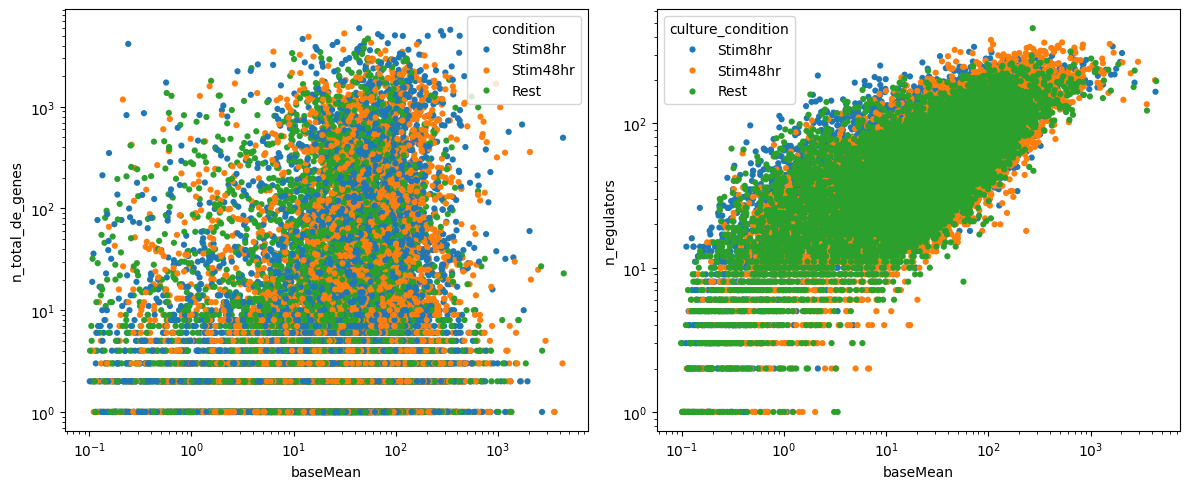

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=DE_stats_targets['baseMean'], y=DE_stats_targets['n_total_de_genes'], 
                hue=DE_stats_targets['condition'], ax=ax1, s=20, linewidth=0)
ax1.set_xscale('log')
ax1.set_yscale('log')

sns.scatterplot(x=DE_stats_genes['baseMean'], y=DE_stats_genes['n_regulators'],
                hue=DE_stats_genes['culture_condition'], ax=ax2, s=20, linewidth=0)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='baseMean', ylabel='Count'>

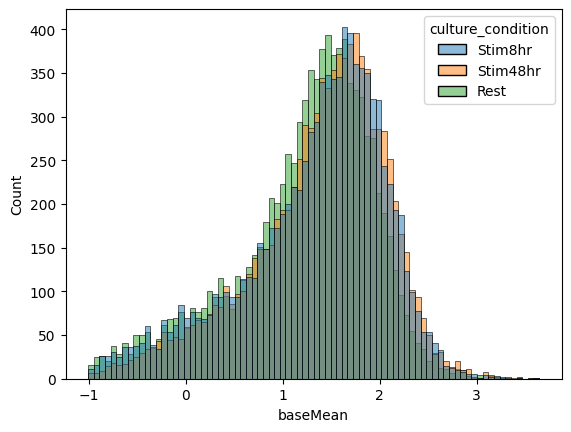

In [11]:
sns.histplot(x=np.log10(DE_stats_genes['baseMean']), hue=DE_stats_genes['culture_condition'])
# sns.histplot(x=DE_stats_genes['n_regulators'], hue=DE_stats_genes['culture_condition'])

## Outgoing effects summary

In [138]:
DE_stats_targets = DE_stats_targets[DE_stats_targets['ontarget_significant']]

# Iterate through culture conditions
results = []
for condition in DE_stats_targets['condition'].unique():
    condition_data = DE_stats_targets[DE_stats_targets['condition'] == condition]
    
    # Iterate through gene lists
    for name, l in lists_dict.items():
        # Get subset of targets data for genes in current list
        df = condition_data[condition_data.target_name.isin(l)]
        
        # For each gene in the list, create a row with group name and DE gene count
        for _, row in df.iterrows():
            results.append({
                'grp': name.split('.')[0],
                'X': row['n_total_de_genes'], 
                'group_mean': df['n_total_de_genes'].mean(),
                'condition': condition
            })
        
    df = condition_data.copy()
    for _, row in df.iterrows():
        results.append({
            'grp': 'all genes',
            'X': row['n_total_de_genes'], 
            'group_mean': df['n_total_de_genes'].mean(),
            'condition': condition
        })

# Convert results to dataframe        
df_filtered = pd.DataFrame(results)
df_filtered[df_filtered['grp'] == 'kinases']
df_filtered['log_X'] = np.log10(df_filtered['X'])
df_filtered['condition'] = pd.Categorical(df_filtered['condition'], categories=['Rest', 'Stim8hr', 'Stim48hr'], ordered=True)

/tmp/ipykernel_1268825/412273049.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
/tmp/ipykernel_1268825/412273049.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()
/tmp/ipykernel_1268825/412273049.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (cond

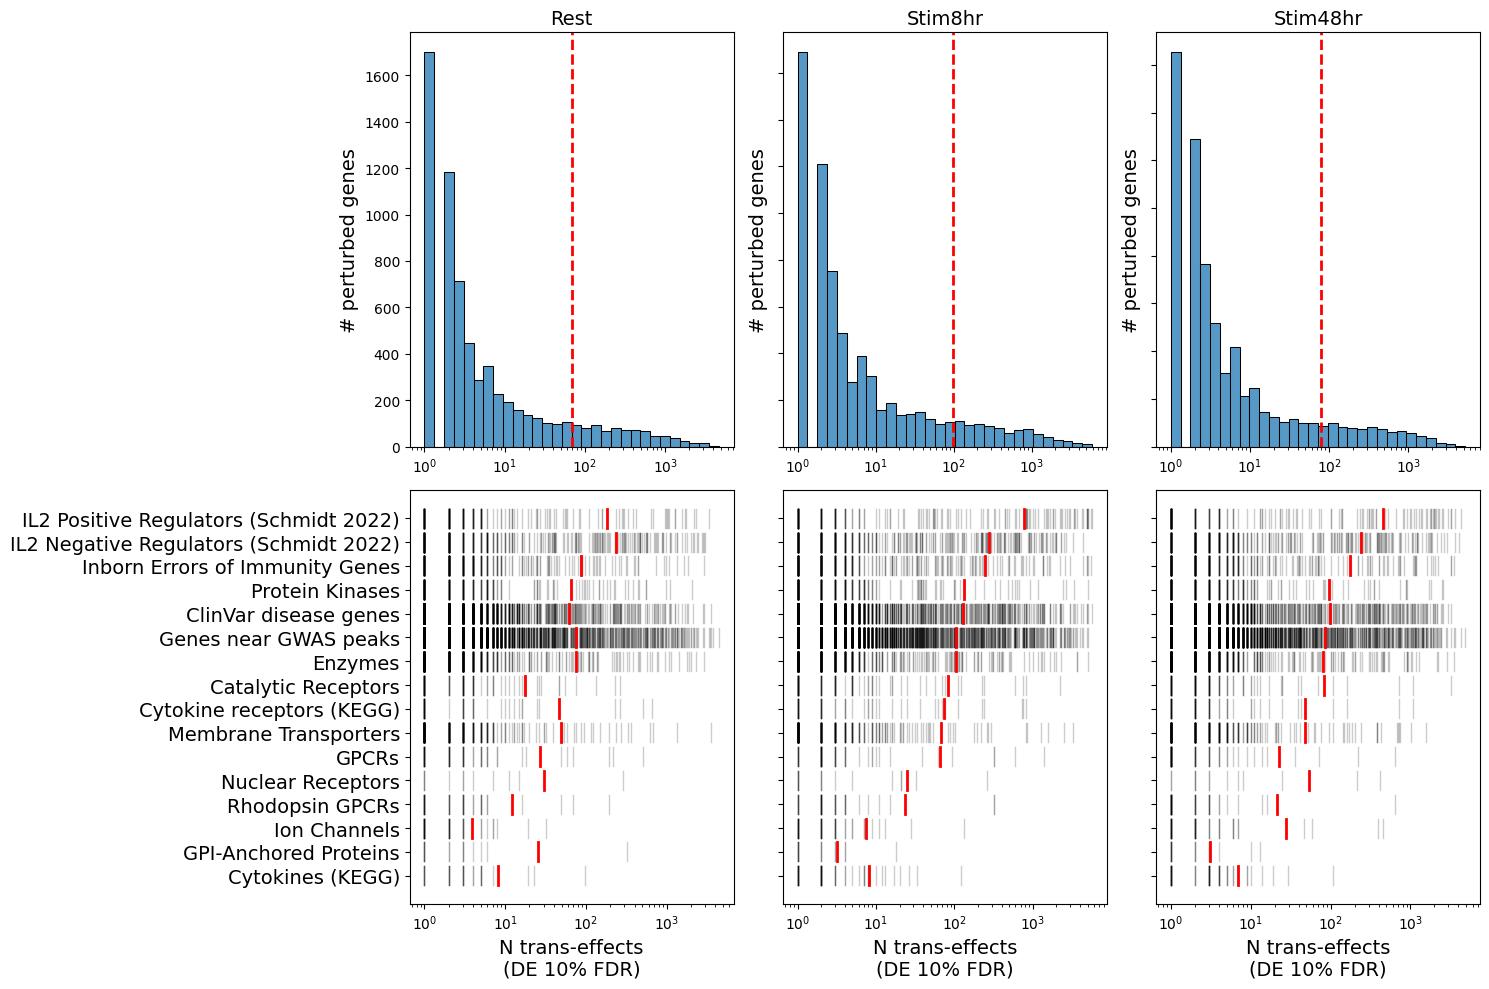

In [139]:
# Calculate mean log_X for each group and sort
group_means = df_filtered.groupby('grp')['X'].mean().sort_values()
sorted_groups = group_means.index.tolist()

# Create figure with 2 rows of 3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), height_ratios=[1, 1])

# Get all genes data for histograms
all_genes_data = df_filtered[df_filtered.grp == 'all genes']

# Plot histograms in top row
for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
    sns.histplot(data=data, x='X', bins=30, ax=axes[0,i], common_norm=False, log_scale=True)
    
    # Add mean as red dotted line
    mean_val = data['X'].mean()
    axes[0,i].axvline(mean_val, color='red', linestyle='--', linewidth=2)
    
    axes[0,i].set_title(condition, fontsize=14)
    axes[0,i].set_xlabel('', fontsize=14)  
    axes[0,i].set_ylabel('# perturbed genes', fontsize=14)
    axes[0,i].tick_params(axis='both', labelsize=10)
    if i > 0:
        axes[0,i].set_yticklabels([])

# Filter data and calculate means for bottom row
filtered_data = df_filtered[df_filtered.grp != 'all genes']
means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()

# Get groups that actually have data (to remove unused y-axis labels)
groups_with_data = filtered_data['grp'].unique()
sorted_groups_with_data = [grp for grp in sorted_groups if grp in groups_with_data]

# Plot stripplots in bottom row
for i, (condition, data) in enumerate(filtered_data.groupby('condition')):
    # Create rug plot - one line per gene
    for j, group in enumerate(sorted_groups_with_data):
        group_data = data[data['grp'] == group]
        
        # Plot horizontal lines for each gene in this group
        for _, gene in group_data.iterrows():
            axes[1,i].plot([gene['X'], gene['X']], [j-0.4, j+0.4], 
                          color='black', alpha=0.2, linewidth=1)
        
        # Calculate and plot mean line
        mean_x = group_data['X'].mean()
        axes[1,i].plot([mean_x, mean_x], [j-0.4, j+0.4],
                      color='red', linewidth=2, zorder=10)
    
    axes[1,i].set_title('')
    axes[1,i].set_xscale('log')
    axes[1,i].set_yticks(range(len(sorted_groups_with_data)))
    axes[1,i].set_yticklabels(sorted_groups_with_data, fontsize=14)
    axes[1,i].set_xlabel('N trans-effects\n(DE 10% FDR)', fontsize=14)
    axes[1,i].tick_params(axis='x', labelsize=10)

    if i > 0:
        axes[1,i].set_yticklabels([])

plt.tight_layout()

In [ ]:
# Calculate mean log_X for each group and sort
group_means = df_filtered.groupby('grp')['X'].mean().sort_values()
sorted_groups = group_means.index.tolist()

# Create figure with 2 subplots in one column
fig, axes = plt.subplots(2, 1, figsize=(10, 10), height_ratios=[1, 2.5], sharex=False)

# Get all genes data for histograms
all_genes_data = df_filtered[df_filtered.grp == 'all genes']

# Define colors for each condition
condition_colors = palettes['culture_condition']

# Plot density lines in top subplot
for condition, data in all_genes_data.groupby('condition'):
    sns.kdeplot(data=data, x='X', ax=axes[0],
                color=condition_colors[condition], alpha=0.5,
                label=condition, linewidth=2, log_scale=True,
                clip=(data['X'].min(), data['X'].max())
                )
    # Add mean as vertical line in same color
    mean_val = data['X'].mean()
    
    # axes[0].hist(np.log10(data['X']), bins=100,
    #              color=condition_colors[condition], alpha=0.5,
    #              label=condition, histtype='step')
    # # axes[0].set_xscale('log')
    # # Add mean as vertical line in same color
    # mean_val = np.log10(data['X'].mean())
    axes[0].axvline(mean_val, color=condition_colors[condition],
                    linestyle='--', linewidth=2)

# Add vertical line at x=0
axes[0].axvline(0, color='grey', linestyle=':', linewidth=1)
axes[0].set_xlabel('', fontsize=14)
axes[0].set_ylabel('# perturbed targets genes', fontsize=14)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].legend(fontsize=12)
sns.despine(ax=axes[0])
# axes[0].set_xscale('log')  # Set x-axis to log scale

# Filter data and calculate means for bottom subplot
filtered_data = df_filtered[df_filtered.grp != 'all genes']
means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()

# Get groups that actually have data
groups_with_data = filtered_data['grp'].unique()
sorted_groups_with_data = [grp for grp in sorted_groups if grp in groups_with_data]

# Add vertical line at x=0
axes[1].axvline(0, color='grey', linestyle=':', linewidth=1)
# Create rug plot - one line per gene, colored by condition
for j, group in enumerate(sorted_groups_with_data):
    group_data = filtered_data[filtered_data['grp'] == group]
    
    # Calculate offsets for each condition to dodge the lines
    conditions = list(condition_colors.keys())
    offsets = {cond: (i-1)*0.25 for i, cond in enumerate(conditions)}
    
    for condition, condition_data in group_data.groupby('condition'):
        # Plot horizontal lines for each gene in this group, with offset
        y_offset = j + offsets[condition]
        for _, gene in condition_data.iterrows():
            axes[1].plot([gene['X'], gene['X']], 
                        [y_offset-0.1, y_offset+0.1],
                        color=condition_colors[condition], 
                        alpha=0.5, linewidth=1)
        
        # Calculate and plot mean line with same offset
        mean_x = condition_data['X'].mean()
        axes[1].plot([mean_x, mean_x], 
                    [y_offset-0.1, y_offset+0.1],
                    color='black', 
                    linewidth=2, zorder=10)

axes[1].set_yticks(range(len(sorted_groups_with_data)))
axes[1].set_yticklabels(sorted_groups_with_data, fontsize=14)
axes[1].set_xlabel('N trans-effects\n(DE 10% FDR)', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].set_xscale('log')  # Set x-axis to log scale
sns.despine(ax=axes[1])

plt.tight_layout()

/tmp/ipykernel_1268825/1102150516.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for condition, data in all_genes_data.groupby('condition'):
/tmp/ipykernel_1268825/1102150516.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()
/tmp/ipykernel_1268825/1102150516.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for condition, condition_

## Incoming effects summary

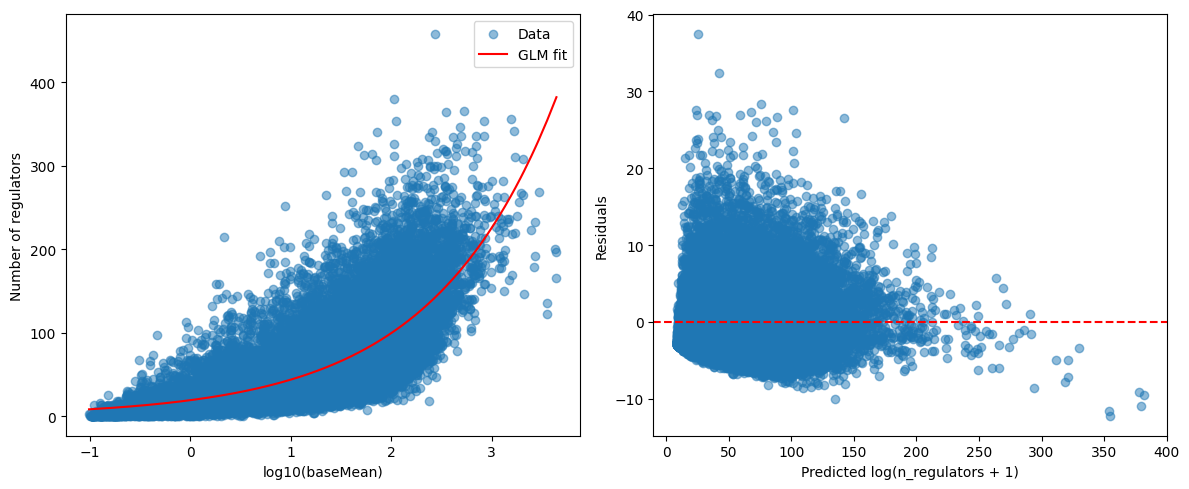

In [108]:
DE_stats_genes = DE_stats_genes[DE_stats_genes['baseMean'] > 0]

from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

# Fit Poisson GLM
X_glm = sm.add_constant(np.log10(DE_stats_genes['baseMean'].values))
poisson_model = sm.GLM(DE_stats_genes['n_regulators'].values, 
                       X_glm, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Get residuals
fitted_values = poisson_results.fittedvalues
residuals = poisson_results.resid_pearson  # Pearson residuals work better for count data
DE_stats_genes['fit_residuals'] = residuals

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the GLM fit
X_plot = np.log10(DE_stats_genes['baseMean'].values)
ax1.scatter(X_plot, DE_stats_genes['n_regulators'].values, alpha=0.5, label='Data')

# Sort X values and get corresponding fitted values for smooth line
sort_idx = np.argsort(X_plot)
X_plot_sorted = X_plot[sort_idx]
fitted_values_sorted = fitted_values[sort_idx]
ax1.plot(X_plot_sorted, fitted_values_sorted, color='red', label='GLM fit')
# ax1.plot(X_plot, fitted_values, color='red', label='GLM fit')
ax1.set_xlabel('log10(baseMean)')
ax1.set_ylabel('Number of regulators')
ax1.legend()

# Plot residuals
y_pred = poisson_results.predict(X_glm)

ax2.scatter(y_pred, residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted log(n_regulators + 1)')
ax2.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

<Axes: xlabel='fit_residuals', ylabel='Count'>

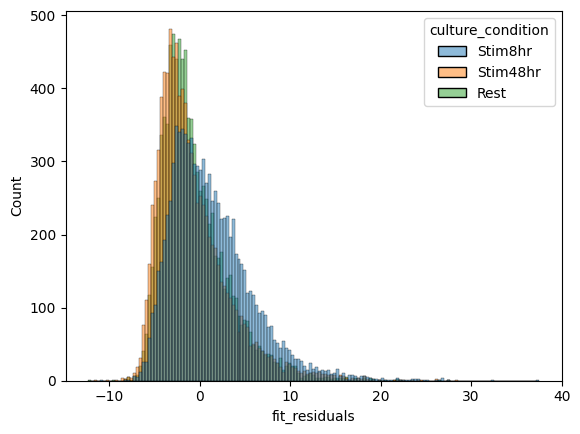

In [109]:
sns.histplot(data=DE_stats_genes, x='fit_residuals', hue='culture_condition')

In [110]:
# Iterate through culture conditions
results = []
for condition in DE_stats_genes['culture_condition'].unique():
    condition_data = DE_stats_genes[DE_stats_genes['culture_condition'] == condition]
    
    # Iterate through gene lists
    for name, l in lists_dict.items():
        # Get subset of targets data for genes in current list
        df = condition_data[condition_data.gene_name.isin(l)]
        
        # For each gene in the list, create a row with group name and DE gene count
        for _, row in df.iterrows():
            results.append({
                'grp': name.split('.')[0],
                'X': row['fit_residuals'], 
                'group_mean': df['fit_residuals'].mean(),
                'condition': condition
            })
        
    df = condition_data.copy()
    for _, row in df.iterrows():
        results.append({
            'grp': 'all genes',
            'X': row['fit_residuals'], 
            'group_mean': df['fit_residuals'].mean(),
            'condition': condition
        })

# Convert results to dataframe        
df_filtered = pd.DataFrame(results)
df_filtered['log_X'] = np.log10(df_filtered['X'])
df_filtered['condition'] = pd.Categorical(df_filtered['condition'], categories=['Rest', 'Stim8hr', 'Stim48hr'], ordered=True)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/tmp/ipykernel_1268825/1676628330.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
/tmp/ipykernel_1268825/1676628330.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()
/tmp/ipykernel_1268825/1676628330.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (c

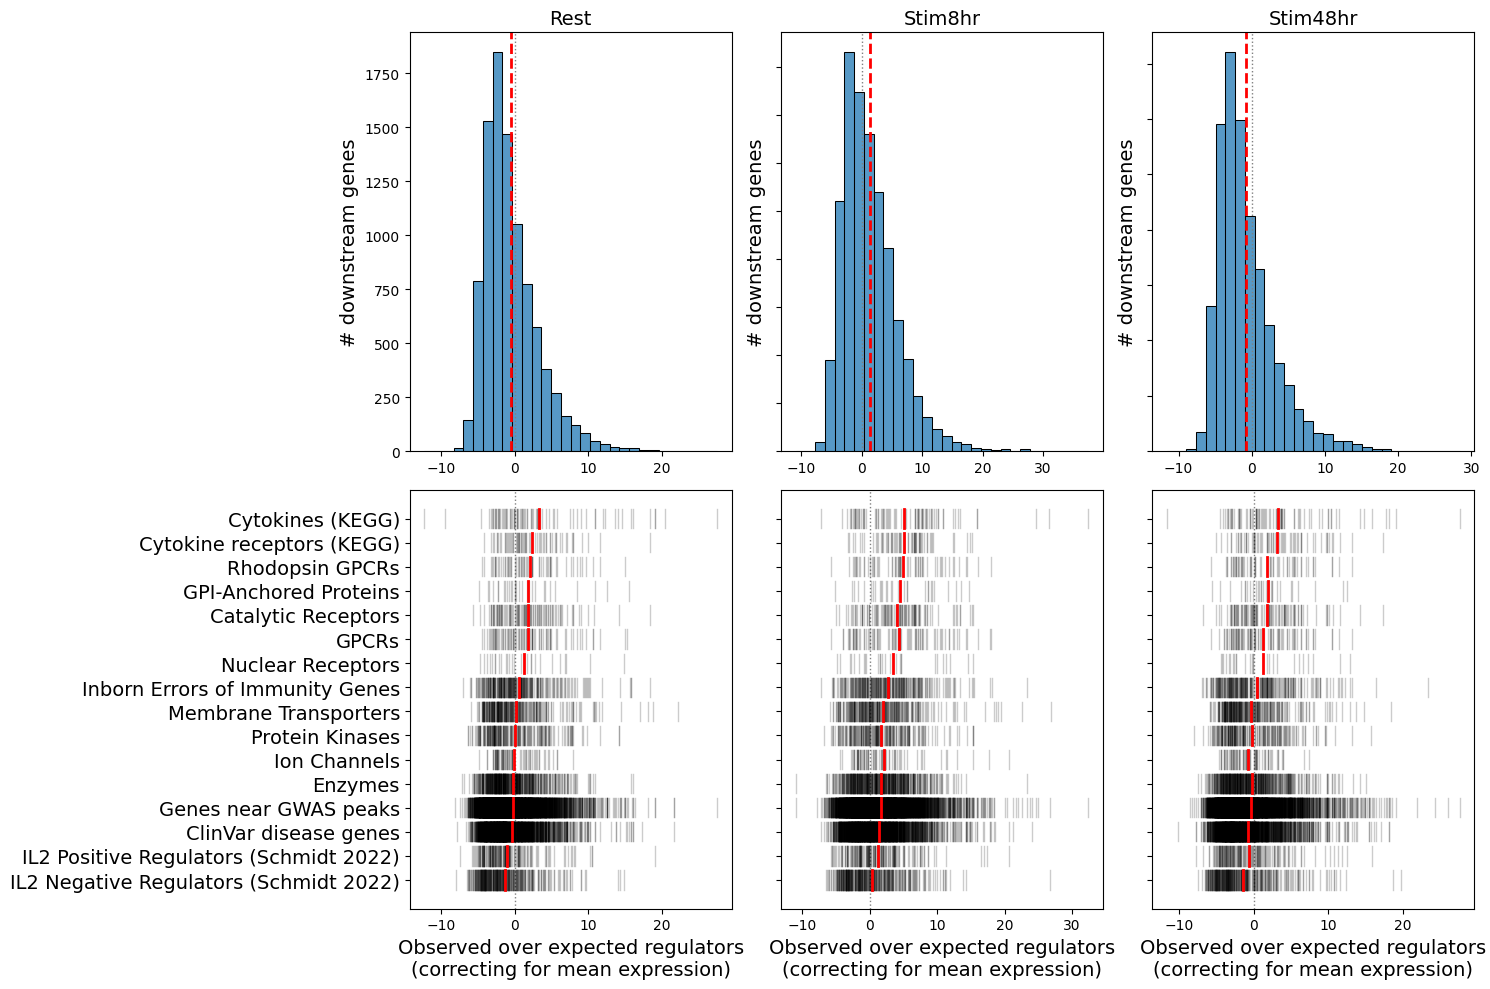

In [111]:
# Calculate mean log_X for each group and sort
group_means = df_filtered.groupby('grp')['X'].mean().sort_values()
sorted_groups = group_means.index.tolist()

# Create figure with 2 rows of 3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), height_ratios=[1, 1])

# Get all genes data for histograms
all_genes_data = df_filtered[df_filtered.grp == 'all genes']

# Plot histograms in top row
for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
    sns.histplot(data=data, x='X', bins=30, ax=axes[0,i], common_norm=False)
    
    # Add mean as red dotted line
    mean_val = data['X'].mean()
    axes[0,i].axvline(mean_val, color='red', linestyle='--', linewidth=2)
    
    # Add vertical line at x=0
    axes[0,i].axvline(0, color='grey', linestyle=':', linewidth=1)
    
    axes[0,i].set_title(condition, fontsize=14)
    axes[0,i].set_xlabel('', fontsize=14)  
    axes[0,i].set_ylabel('# downstream genes', fontsize=14)
    axes[0,i].tick_params(axis='both', labelsize=10)
    if i > 0:
        axes[0,i].set_yticklabels([])

# Filter data and calculate means for bottom row
filtered_data = df_filtered[df_filtered.grp != 'all genes']
means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()

# Get groups that actually have data (to remove unused y-axis labels)
groups_with_data = filtered_data['grp'].unique()
sorted_groups_with_data = [grp for grp in sorted_groups if grp in groups_with_data]

# Plot stripplots in bottom row
for i, (condition, data) in enumerate(filtered_data.groupby('condition')):
    # Add vertical line at x=0
    axes[1,i].axvline(0, color='grey', linestyle=':', linewidth=1)
    
    # Create rug plot - one line per gene
    for j, group in enumerate(sorted_groups_with_data):
        group_data = data[data['grp'] == group]
        
        # Plot horizontal lines for each gene in this group
        for _, gene in group_data.iterrows():
            axes[1,i].plot([gene['X'], gene['X']], [j-0.4, j+0.4], 
                          color='black', alpha=0.2, linewidth=1)
        
        # Calculate and plot mean line
        mean_x = group_data['X'].mean()
        axes[1,i].plot([mean_x, mean_x], [j-0.4, j+0.4],
                      color='red', linewidth=2, zorder=10)
    
    axes[1,i].set_title('')
    # axes[1,i].set_xscale('log')
    axes[1,i].set_yticks(range(len(sorted_groups_with_data)))
    axes[1,i].set_yticklabels(sorted_groups_with_data, fontsize=14)
    axes[1,i].set_xlabel('Observed over expected regulators\n(correcting for mean expression)', fontsize=14)
    axes[1,i].tick_params(axis='x', labelsize=10)

    if i > 0:
        axes[1,i].set_yticklabels([])

plt.tight_layout()

/tmp/ipykernel_1268825/1767044953.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for condition, data in all_genes_data.groupby('condition'):
/tmp/ipykernel_1268825/1767044953.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()
/tmp/ipykernel_1268825/1767044953.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for condition, condition_

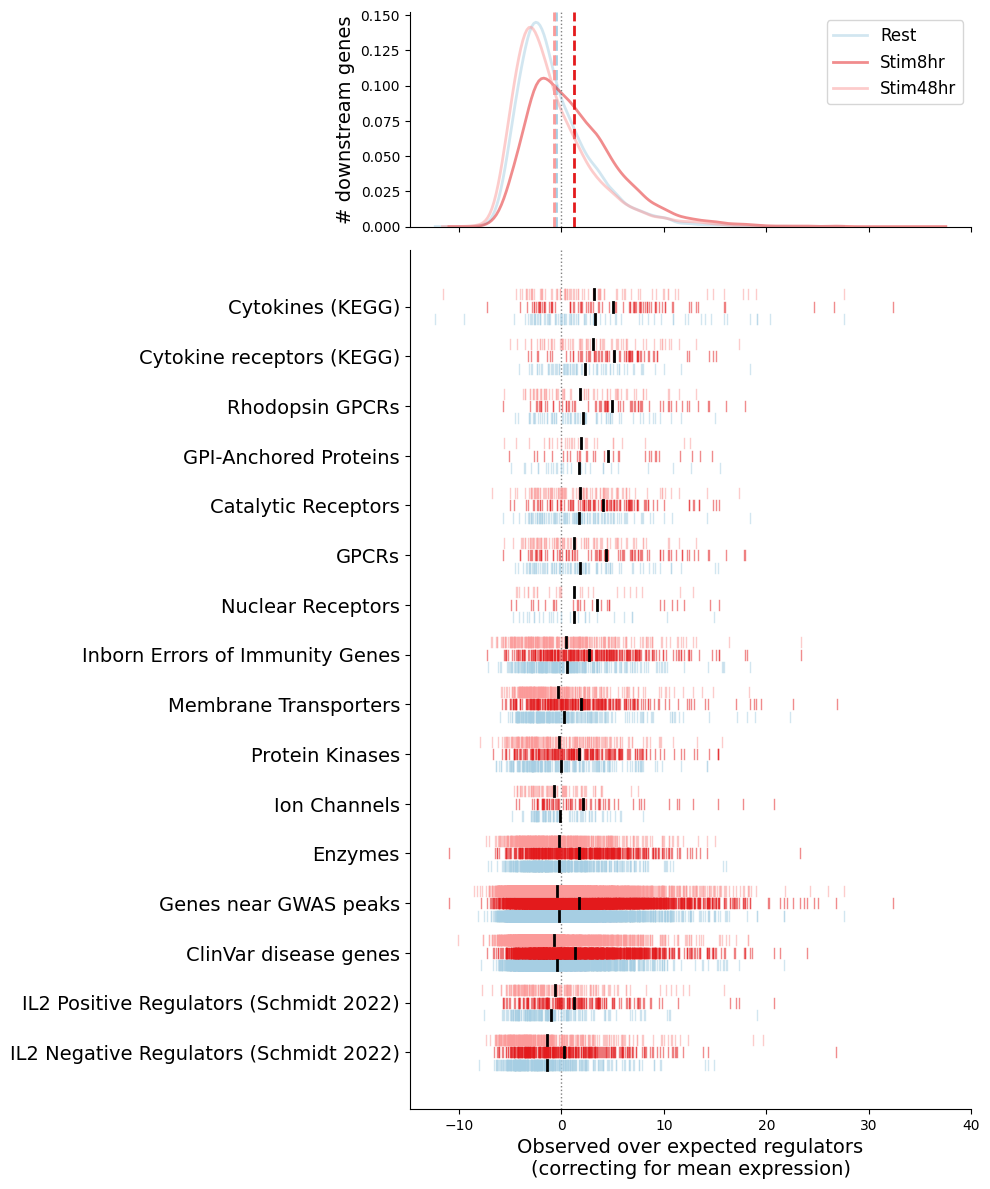

In [114]:
# Calculate mean log_X for each group and sort
group_means = df_filtered.groupby('grp')['X'].mean().sort_values()
sorted_groups = group_means.index.tolist()

# Create figure with 2 subplots in one column
fig, axes = plt.subplots(2, 1, figsize=(10, 12), height_ratios=[0.5, 2], sharex=True)

# Get all genes data for histograms
all_genes_data = df_filtered[df_filtered.grp == 'all genes']

# Define colors for each condition
condition_colors = palettes['culture_condition']

# Plot density lines in top subplot
for condition, data in all_genes_data.groupby('condition'):
    sns.kdeplot(data=data, x='X', ax=axes[0],
                color=condition_colors[condition], alpha=0.5,
                label=condition, linewidth=2,
                clip=(data['X'].min(), data['X'].max()))
    # Add mean as vertical line in same color
    mean_val = data['X'].mean()
    axes[0].axvline(mean_val, color=condition_colors[condition],
                    linestyle='--', linewidth=2)

# Add vertical line at x=0
axes[0].axvline(0, color='grey', linestyle=':', linewidth=1)
axes[0].set_xlabel('', fontsize=14)
axes[0].set_ylabel('# downstream genes', fontsize=14)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].legend(fontsize=12)
sns.despine(ax=axes[0])

# Filter data and calculate means for bottom subplot
filtered_data = df_filtered[df_filtered.grp != 'all genes']
means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()

# Get groups that actually have data
groups_with_data = filtered_data['grp'].unique()
sorted_groups_with_data = [grp for grp in sorted_groups if grp in groups_with_data]

# Add vertical line at x=0
axes[1].axvline(0, color='grey', linestyle=':', linewidth=1)
# Create rug plot - one line per gene, colored by condition
for j, group in enumerate(sorted_groups_with_data):
    group_data = filtered_data[filtered_data['grp'] == group]
    
    # Calculate offsets for each condition to dodge the lines
    conditions = list(condition_colors.keys())
    offsets = {cond: (i-1)*0.25 for i, cond in enumerate(conditions)}
    
    for condition, condition_data in group_data.groupby('condition'):
        # Plot horizontal lines for each gene in this group, with offset
        y_offset = j + offsets[condition]
        for _, gene in condition_data.iterrows():
            axes[1].plot([gene['X'], gene['X']], 
                        [y_offset-0.1, y_offset+0.1],
                        color=condition_colors[condition], 
                        alpha=0.5, linewidth=1)
        
        # Calculate and plot mean line with same offset
        mean_x = condition_data['X'].mean()
        axes[1].plot([mean_x, mean_x], 
                    [y_offset-0.1, y_offset+0.1],
                    color='black', 
                    linewidth=2, zorder=10)

axes[1].set_yticks(range(len(sorted_groups_with_data)))
axes[1].set_yticklabels(sorted_groups_with_data, fontsize=14)
axes[1].set_xlabel('Observed over expected regulators\n(correcting for mean expression)', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10)
sns.despine(ax=axes[1])

plt.tight_layout()

In [73]:
DE_stats_genes[['gene_name', 'fit_residuals', 'culture_condition']].sort_values('fit_residuals', ascending=False)[0:30]

,gene_name,fit_residuals,culture_condition
3484,STC2,37.517060,Stim8hr
3384,VEGFA,32.400827,Stim8hr
15220,SESN1,28.383678,Stim48hr
22918,IL3,27.570734,Stim48hr
31302,VEGFA,27.541238,Rest
13779,TXNIP,27.364865,Stim8hr
4967,CHAC1,26.957196,Stim8hr
7496,SLC7A11,26.943183,Stim8hr
7118,PNRC1,26.868566,Stim8hr
4842,KLF2,26.792851,Stim8hr


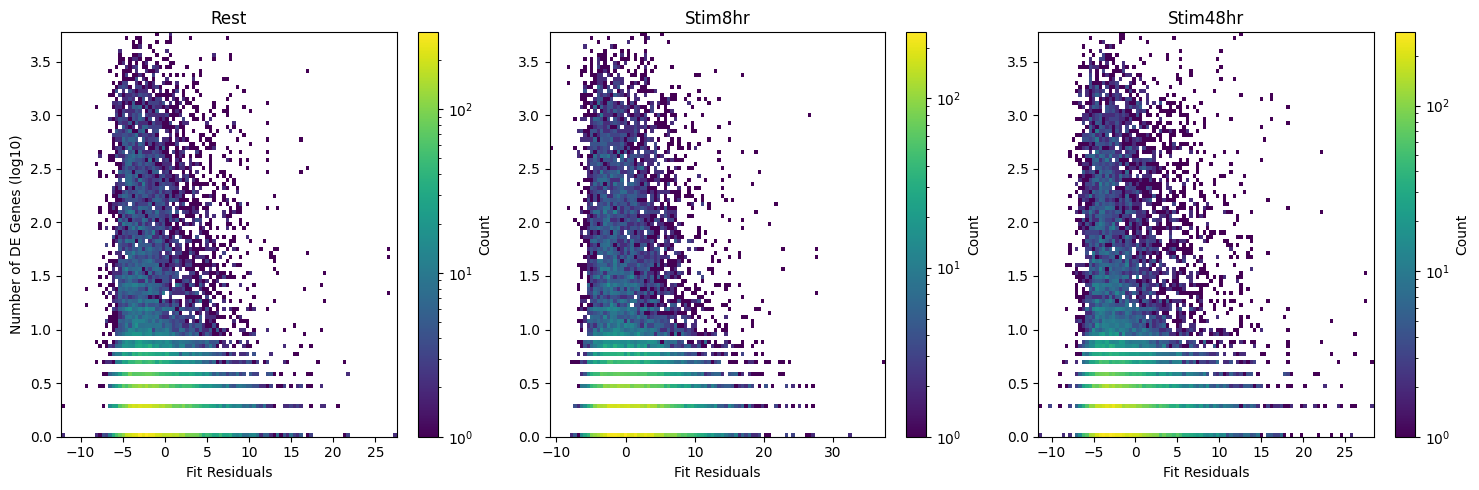

In [50]:
joined_stats = pd.merge(DE_stats_genes[['gene_name', 'fit_residuals', 'culture_condition']].rename(columns={'culture_condition':'condition', 'gene_name':'target_name'}), DE_stats_targets[['target_name', 'n_total_de_genes']], how='inner')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
conditions = ['Rest', 'Stim8hr', 'Stim48hr']

for i, condition in enumerate(conditions):
    condition_data = joined_stats[joined_stats['condition'] == condition]
    
    h = axes[i].hist2d(condition_data['fit_residuals'], 
                      np.log10(condition_data['n_total_de_genes']),
                      bins=100, cmap='viridis', 
                      norm=matplotlib.colors.LogNorm())
    
    axes[i].set_xlabel('Fit Residuals')
    if i == 0:
        axes[i].set_ylabel('Number of DE Genes (log10)')
    axes[i].set_title(condition)
    
    plt.colorbar(h[3], ax=axes[i], label='Count')

plt.tight_layout()
plt.show()

In [ ]:
DE_stats_targets = DE_stats_targets[DE_stats_targets['ontarget_significant']]

# Iterate through culture conditions
results = []
for condition in DE_stats_targets['condition'].unique():
    condition_data = DE_stats_targets[DE_stats_targets['condition'] == condition]
    
    # Iterate through gene lists
    for name, l in lists_dict.items():
        # Get subset of targets data for genes in current list
        df = condition_data[condition_data.target_name.isin(l)]
        
        # For each gene in the list, create a row with group name and DE gene count
        for _, row in df.iterrows():
            results.append({
                'grp': name.split('.')[0],
                'X': row['n_total_de_genes'], 
                'group_mean': df['n_total_de_genes'].mean(),
                'condition': condition
            })
        
    df = condition_data.copy()
    for _, row in df.iterrows():
        results.append({
            'grp': 'all genes',
            'X': row['n_total_de_genes'], 
            'group_mean': df['n_total_de_genes'].mean(),
            'condition': condition
        })

# Convert results to dataframe        
df_filtered = pd.DataFrame(results)
df_filtered[df_filtered['grp'] == 'kinases']
df_filtered['log_X'] = np.log10(df_filtered['X'])
df_filtered['condition'] = pd.Categorical(df_filtered['condition'], categories=['Rest', 'Stim8hr', 'Stim48hr'], ordered=True)

/tmp/ipykernel_1268825/412273049.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
/tmp/ipykernel_1268825/412273049.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()
/tmp/ipykernel_1268825/412273049.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (cond

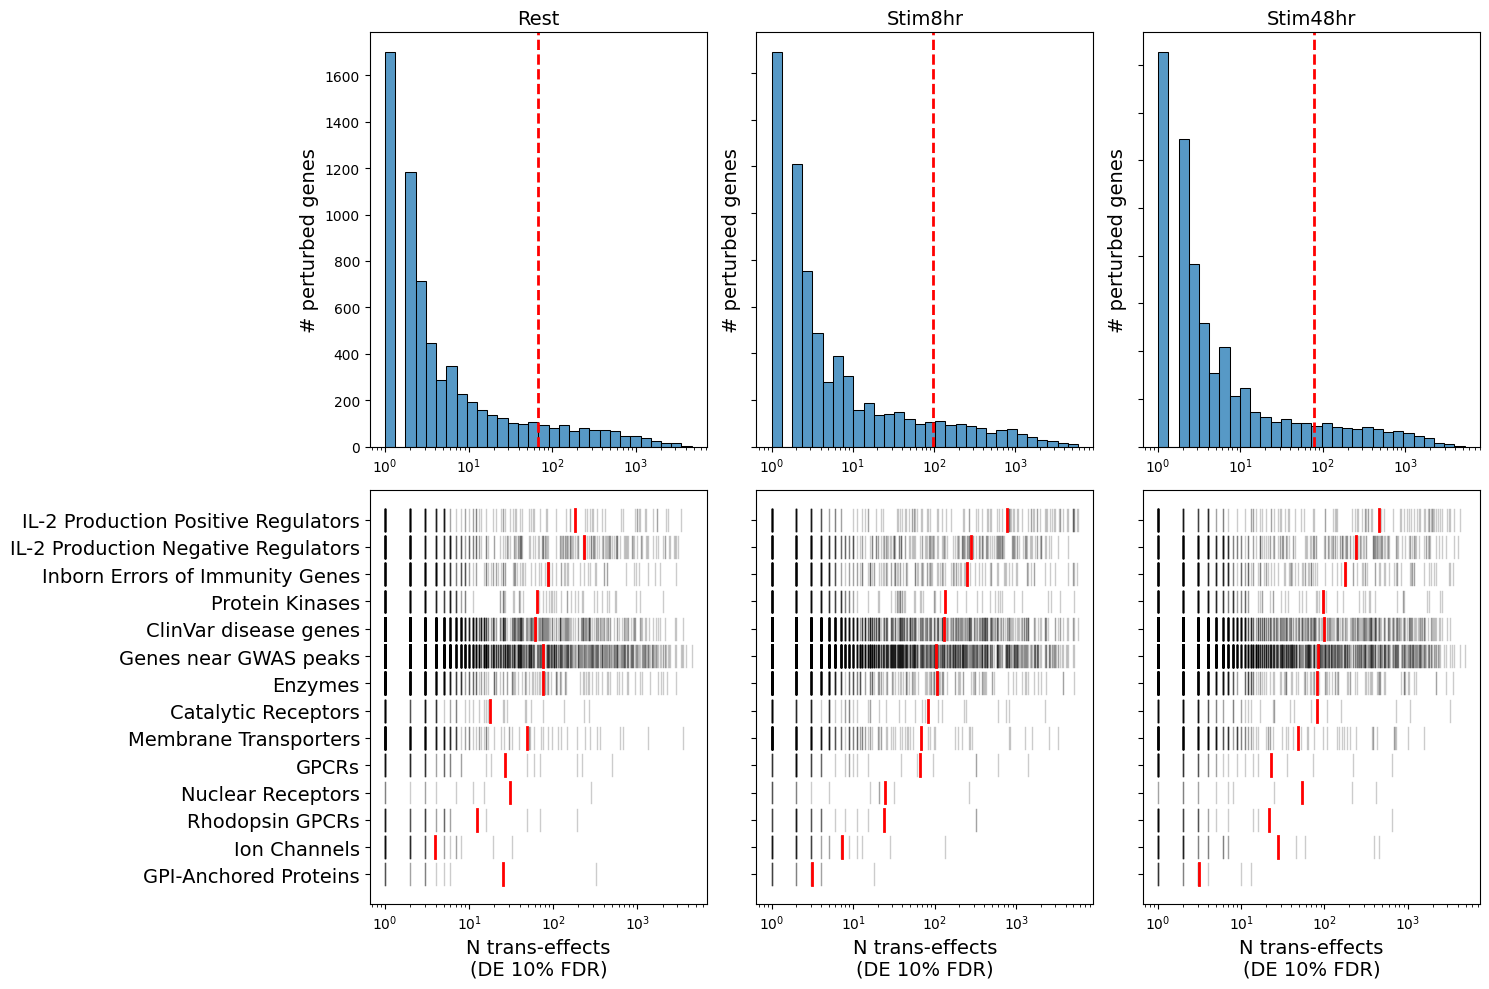

In [ ]:
# Calculate mean log_X for each group and sort
group_means = df_filtered.groupby('grp')['X'].mean().sort_values()
sorted_groups = group_means.index.tolist()

# Create figure with 2 rows of 3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), height_ratios=[1, 1])

# Get all genes data for histograms
all_genes_data = df_filtered[df_filtered.grp == 'all genes']

# Plot histograms in top row
for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
    sns.histplot(data=data, x='X', bins=30, ax=axes[0,i], common_norm=False, log_scale=True)
    
    # Add mean as red dotted line
    mean_val = data['X'].mean()
    axes[0,i].axvline(mean_val, color='red', linestyle='--', linewidth=2)
    
    axes[0,i].set_title(condition, fontsize=14)
    axes[0,i].set_xlabel('', fontsize=14)  
    axes[0,i].set_ylabel('# perturbed genes', fontsize=14)
    axes[0,i].tick_params(axis='both', labelsize=10)
    if i > 0:
        axes[0,i].set_yticklabels([])

# Filter data and calculate means for bottom row
filtered_data = df_filtered[df_filtered.grp != 'all genes']
means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()

# Get groups that actually have data (to remove unused y-axis labels)
groups_with_data = filtered_data['grp'].unique()
sorted_groups_with_data = [grp for grp in sorted_groups if grp in groups_with_data]

# Plot stripplots in bottom row
for i, (condition, data) in enumerate(filtered_data.groupby('condition')):
    # Create rug plot - one line per gene
    for j, group in enumerate(sorted_groups_with_data):
        group_data = data[data['grp'] == group]
        
        # Plot horizontal lines for each gene in this group
        for _, gene in group_data.iterrows():
            axes[1,i].plot([gene['X'], gene['X']], [j-0.4, j+0.4], 
                          color='black', alpha=0.2, linewidth=1)
        
        # Calculate and plot mean line
        mean_x = group_data['X'].mean()
        axes[1,i].plot([mean_x, mean_x], [j-0.4, j+0.4],
                      color='red', linewidth=2, zorder=10)
    
    axes[1,i].set_title('')
    axes[1,i].set_xscale('log')
    axes[1,i].set_yticks(range(len(sorted_groups_with_data)))
    axes[1,i].set_yticklabels(sorted_groups_with_data, fontsize=14)
    axes[1,i].set_xlabel('N trans-effects\n(DE 10% FDR)', fontsize=14)
    axes[1,i].tick_params(axis='x', labelsize=10)

    if i > 0:
        axes[1,i].set_yticklabels([])

plt.tight_layout()

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, '−1000'),
  Text(0.0, 0, '0'),
  Text(1000.0, 0, '1000'),
  Text(2000.0, 0, '2000'),
  Text(3000.0, 0, '3000'),
  Text(4000.0, 0, '4000'),
  Text(5000.0, 0, '5000'),
  Text(6000.0, 0, '6000'),
  Text(7000.0, 0, '7000')])

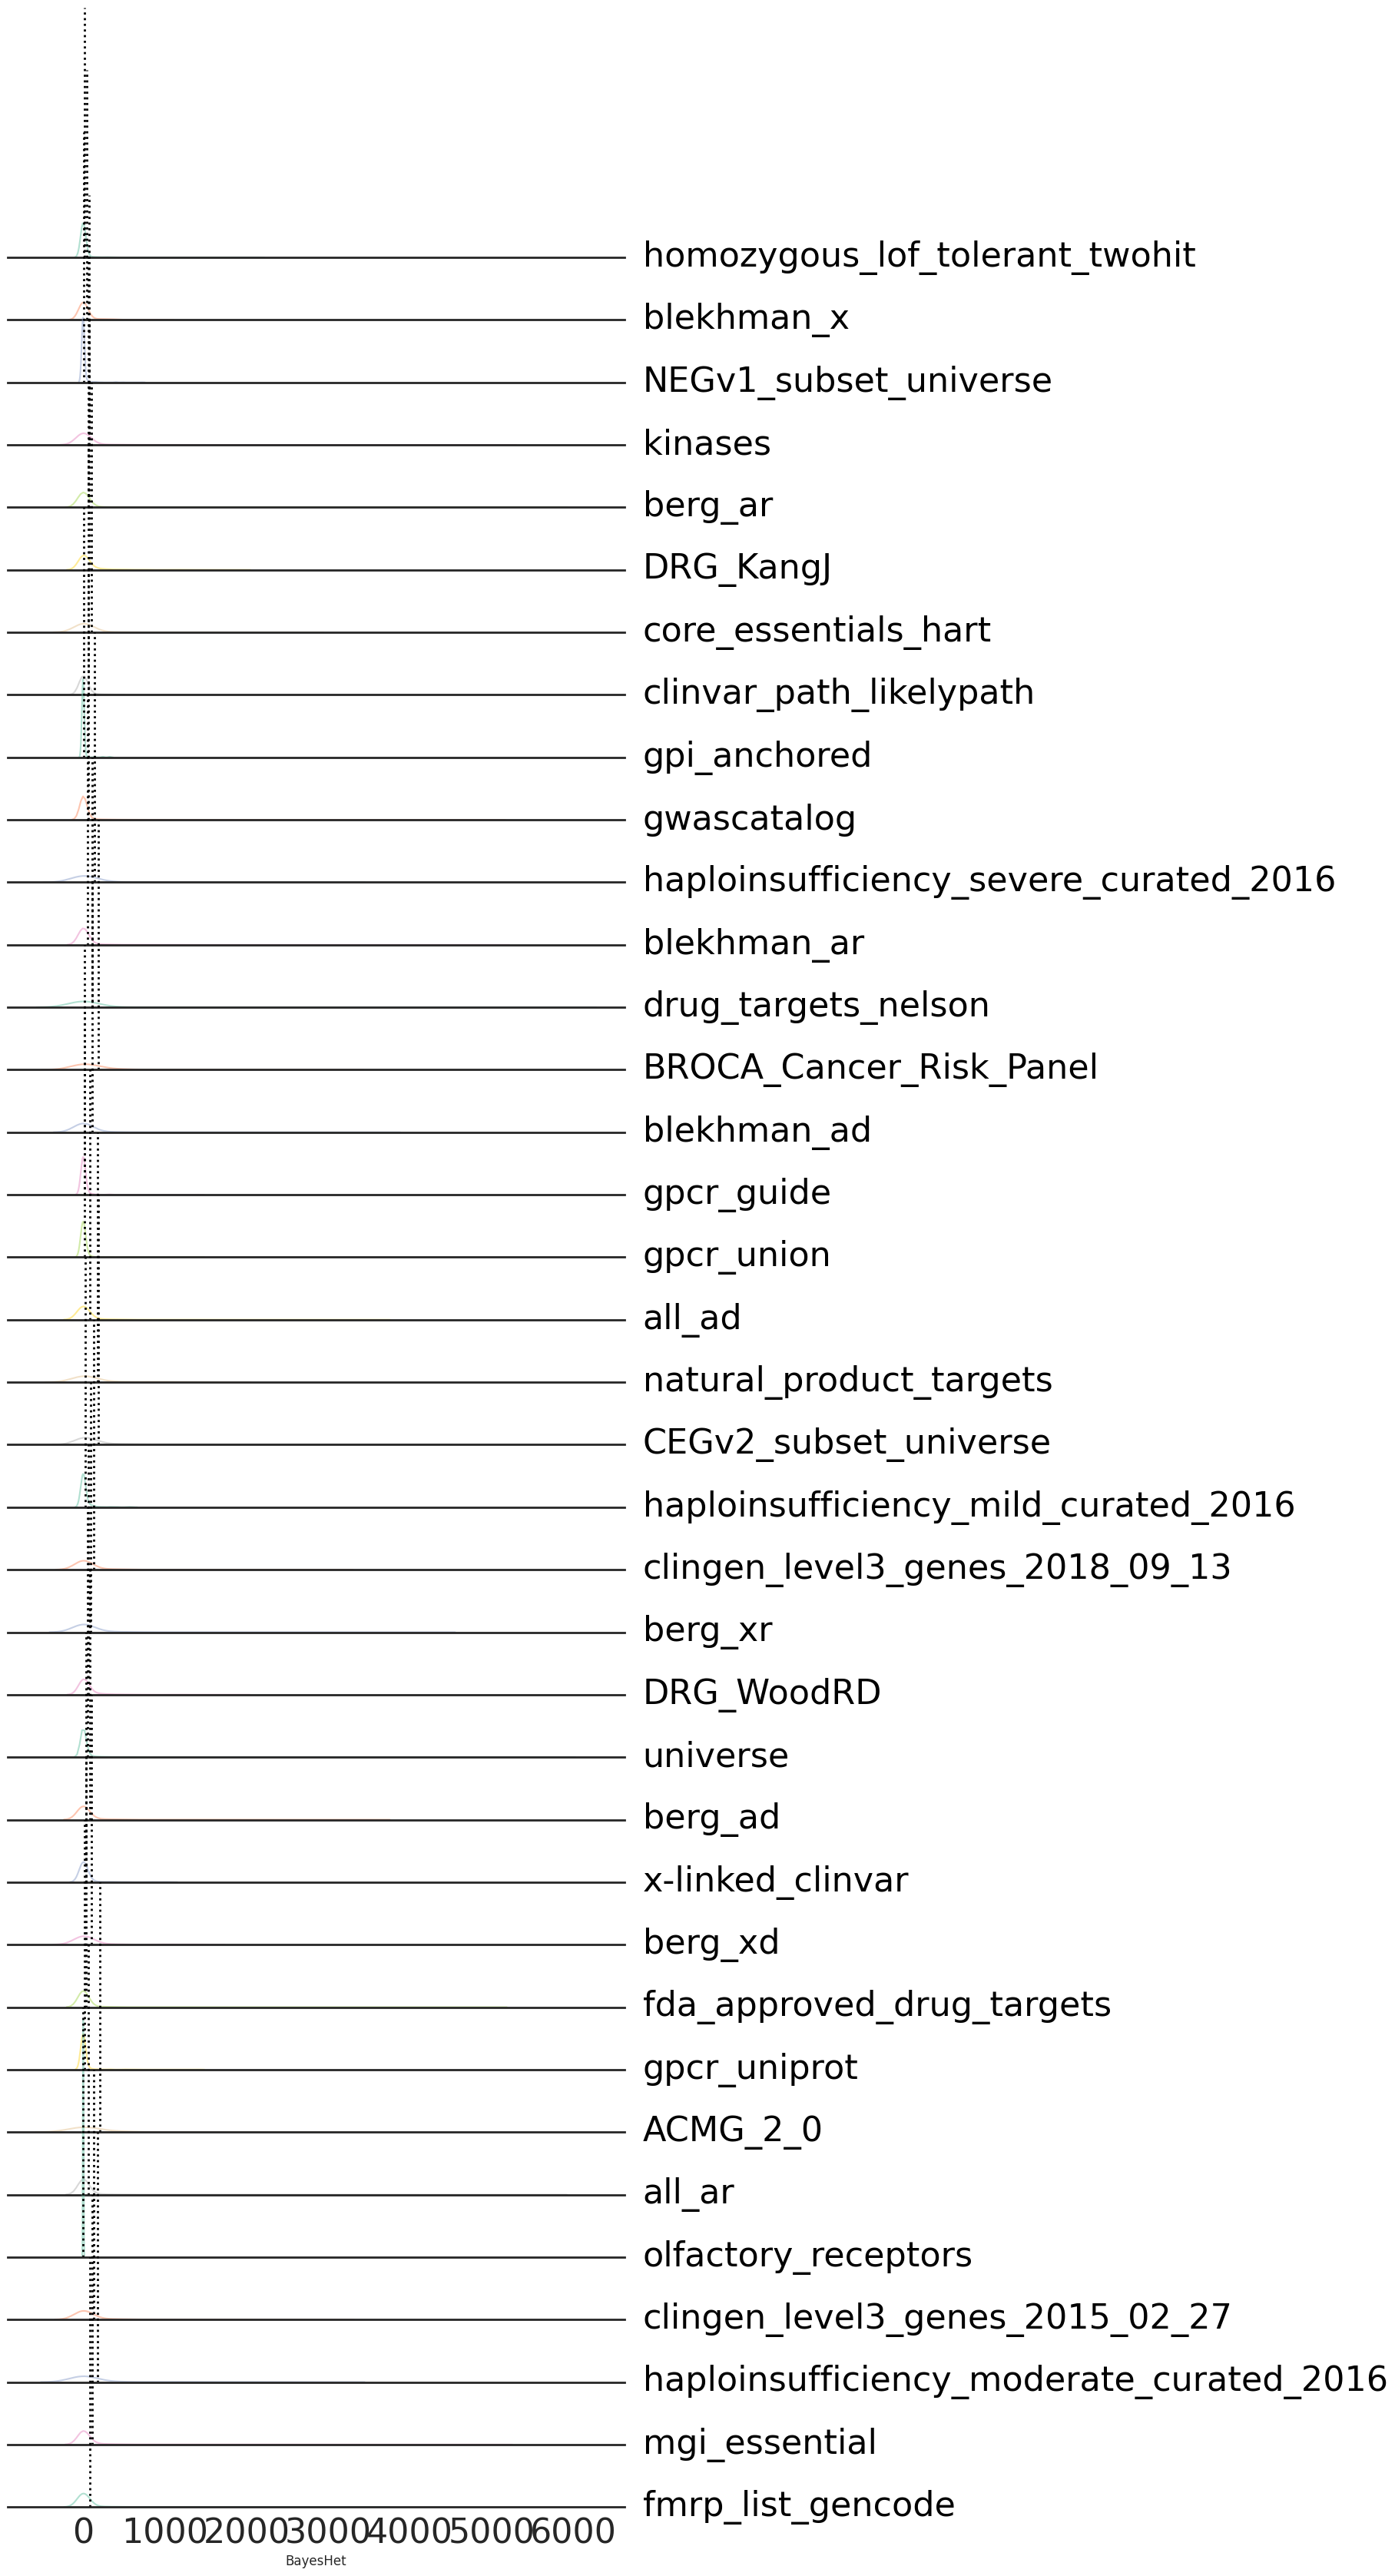

In [ ]:

# matplotlib.rcParams['font.family'] = ['Arial']
# matplotlib.rcParams['text.color'] = "black"
# matplotlib.rcParams['axes.labelcolor'] = "black"
# matplotlib.rcParams['xtick.color'] = "black"
# matplotlib.rcParams['ytick.color'] = "black"

# fs = 32
# params = {'axes.labelsize': fs, 'axes.titlesize': fs, 'legend.fontsize': fs, 'legend.title_fontsize': fs, 'xtick.labelsize': fs, 'ytick.labelsize': fs}
# matplotlib.rcParams.update(params)
# sns.set_style("white")

# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
# palette = sns.color_palette("Set2", 12)
# g = sns.FacetGrid(df_filtered, palette=palette, row="grp", hue="grp", aspect=10, height=20/22)
# g.map_dataframe(sns.kdeplot, x="X", fill=False, alpha=0.5)

# def add_mean_line(x, color, label):
#     ax = plt.gca()
#     mean = df_filtered[df_filtered['grp'] == label]['group_mean'].values[0]
#     ax.axvline(x=mean, color='black', linestyle=':', linewidth=2)
#     ax.text(1.03, .0, label, color='black', fontsize=fs,
#             ha="left", va="center", transform=ax.transAxes)

# g.map(add_mean_line, "grp")
# g.fig.subplots_adjust(hspace=-0.75)
# g.set_titles("")
# g.set(yticks=[], xla
# bel="BayesHet", ylabel="")
# g.despine(left=True)
# plt.xticks(fontsize=fs)

# # plt.xlim(1e-5, 1)
# # plt.xscale("log")

# # plt.savefig("../plots/ridge.s_het.pdf", transparent=True, bbox_inches="tight")


In [88]:
df_filtered

,group,gene,n_de_genes,group_mean
0,homozygous_lof_tolerant_twohit,ZNF486,3,15.304740
1,homozygous_lof_tolerant_twohit,COL16A1,2,15.304740
2,homozygous_lof_tolerant_twohit,CD36,2,15.304740
3,homozygous_lof_tolerant_twohit,ZNF417,3,15.304740
4,homozygous_lof_tolerant_twohit,ZNF417,3,15.304740
...,...,...,...,...
74225,fmrp_list_gencode,SORL1,16,87.235079
74226,fmrp_list_gencode,CCAR2,31,87.235079
74227,fmrp_list_gencode,SMARCA2,3,87.235079
74228,fmrp_list_gencode,AKAP9,4,87.235079
